# Data Importing

In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import miceforest as mf
import optuna
import lightgbm as lgb
import xgboost as xgb

from utils import *
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import metrics
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('../data/processed/after_prep.csv')
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Brand,Series,Type,Mileage (kmpl),Engine (CC),Power (bhp)
0,Mumbai,2010,72000,CNG,Manual,First,5.0,1.75,Maruti,Wagon,R,26.60,998.0,58.16
1,Pune,2015,41000,Diesel,Manual,First,5.0,12.50,Hyundai,Creta,1.6,19.67,1582.0,126.20
2,Chennai,2011,46000,Petrol,Manual,First,5.0,4.50,Honda,Jazz,V,18.20,1199.0,88.70
3,Chennai,2012,87000,Diesel,Manual,First,7.0,6.00,Maruti,Ertiga,VDI,20.77,1248.0,88.76
4,Coimbatore,2013,40670,Diesel,Automatic,Second,5.0,17.74,Audi,A4,New,15.20,1968.0,140.80


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Seats              5976 non-null   float64
 7   Price              6019 non-null   float64
 8   Brand              6019 non-null   object 
 9   Series             6019 non-null   object 
 10  Type               6019 non-null   object 
 11  Mileage (kmpl)     5951 non-null   float64
 12  Engine (CC)        5983 non-null   float64
 13  Power (bhp)        5876 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 658.5+ KB


# Preprocessing

In [4]:
# Delete outlier
df = df[~(df.Kilometers_Driven > 1e6)]
df.shape

(6018, 14)

## Train test split

In [5]:
# melakukan train test split di awal untuk mencegah data bocor ke test set saat dilakukan encoding/imputation
features = df.drop(columns=['Price'])
target = df['Price']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0)

## Encoding

In [6]:
# # One hot encoding
# col_to_encode = ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Brand']
# oh_encoder = ce.OneHotEncoder(cols=col_to_encode,
#                               use_cat_names=True)
# oh_encoder.fit(X_train)

# # Encoding train set
# X_train = oh_encoder.transform(X_train)
# # Encoding test set
# X_test = oh_encoder.transform(X_test)

In [7]:
# Target encoding
col_to_encode = ['Series', 'Type', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Brand']
target_encoder = ce.TargetEncoder(cols=col_to_encode)
target_encoder.fit(X_train, y_train)

# Encoding train set
X_train = target_encoder.transform(X_train)
# Encoding test set
X_test = target_encoder.transform(X_test)

## Missing Value Imputation

In [8]:
# memprediksi nilai missing value dengan algoritma 
imputer = mf.KernelDataSet(
  X_train,
  save_all_iterations=True,
  random_state=1991,
  mean_match_candidates=5
)

imputer.mice(10)

In [9]:
# Train set imputation
X_train_full = imputer.complete_data()

In [10]:
# Test set imputation
new_data = imputer.impute_new_data(X_test)
X_test_full = new_data.complete_data()

# Modeling

## Functions

In [11]:
def get_cv_score(models, X_train, y_train):
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    summary = []
    for label, model in models.items():
        cv_results = cross_validate(model, X_train, y_train, cv=cv, 
                                    scoring=['r2',
                                             'neg_root_mean_squared_error',
                                             'neg_mean_absolute_error'])
        
        temp = pd.DataFrame(cv_results).copy()
        temp['Model'] = label
        summary.append(temp)
    
    summary = pd.concat(summary)
    summary = summary.groupby('Model').mean()
    
    summary.drop(columns=['fit_time', 'score_time'], inplace=True)
    summary.columns = ['CV R2', 'CV RMSE', 'CV MAE']
    summary[['CV RMSE', 'CV MAE']] = summary[['CV RMSE', 'CV MAE']] * -1
    
    return summary

In [12]:
def evaluate_model(models, X_train, X_test, y_train, y_test):

    summary = {'Model':[], 'Train R2':[], 'Train RMSE':[], 'Train MAE':[],
               'Test R2':[], 'Test RMSE':[], 'Test MAE':[]}

    for label, model in models.items():
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        summary['Model'].append(label)

        summary['Train R2'].append(
            metrics.r2_score(y_train, y_train_pred))
        summary['Train RMSE'].append(
            np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
        summary['Train MAE'].append(
            metrics.mean_absolute_error(y_train, y_train_pred))

        summary['Test R2'].append(
            metrics.r2_score(y_test, y_test_pred))
        summary['Test RMSE'].append(
            np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
        summary['Test MAE'].append(
            metrics.mean_absolute_error(y_test, y_test_pred))
    
    summary = pd.DataFrame(summary)
    summary.set_index('Model', inplace=True)

    cv_scores = get_cv_score(models, X_train, y_train)
    summary = summary.join(cv_scores)
    summary = summary[['Train R2', 'CV R2', 'Test R2',
                       'Train RMSE', 'CV RMSE', 'Test RMSE',
                       'Train MAE', 'CV MAE', 'Test MAE']]
    
    return round(summary.sort_values(by='CV RMSE'), 4)

## Base Model

In [14]:
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()
xgb_model = XGBRegressor(objective='reg:squarederror')
lgb_model = LGBMRegressor()
cat_model = CatBoostRegressor(silent=True)
lr_model = LinearRegression()
lasso_model = Lasso()

models = {'DecisionTreeRegressor' : tree_model,
          'RandomForestRegressor' : rf_model,
          'XGBRegressor' : xgb_model,
          'CatBoostRegressor' : cat_model,
          'LGBMRegressor' : lgb_model,
          'LinearRegression': lr_model,
          'LassoRegression': lasso_model}

### Unscaled dataset

In [14]:
# evaluasi model memakai function
unscaled = evaluate_model(models, X_train_full, X_test_full, y_train, y_test)

### Scaled dataset

In [15]:
# Scaling data
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(X_train_full)
X_train_full_scaled = scaler.transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test_full)

In [16]:
# evaluasi model memakai function
scaled = evaluate_model(models, X_train_full_scaled, X_test_full_scaled, y_train, y_test)

### Summarizing

In [17]:
unscaled['Dataset Version'] = 'imputed + all + unscaled'
scaled['Dataset Version'] = 'imputed + all + scaled'

In [18]:
imputed_all = pd.concat([unscaled, scaled], axis=0)
imputed_all

,Train R2,CV R2,Test R2,Train RMSE,CV RMSE,Test RMSE,Train MAE,CV MAE,Test MAE,Dataset Version
Model,,,,,,,,,,
CatBoostRegressor,0.9926,0.9245,0.9119,0.9559,3.0379,3.3892,0.6334,1.1790,1.1579,imputed + all + unscaled
LGBMRegressor,0.9712,0.9162,0.9099,1.8815,3.1966,3.4266,0.8291,1.2691,1.2578,imputed + all + unscaled
RandomForestRegressor,0.9876,0.9100,0.9016,1.2340,3.3141,3.5818,0.4874,1.3278,1.3780,imputed + all + unscaled
XGBRegressor,0.9976,0.9094,0.8945,0.5408,3.3216,3.7071,0.3753,1.2601,1.2720,imputed + all + unscaled
DecisionTreeRegressor,1.0000,0.8011,0.8581,0.0129,4.9092,4.3004,0.0006,1.9027,1.8647,imputed + all + unscaled
LinearRegression,0.8015,0.7974,0.7778,4.9365,4.9799,5.3815,2.7206,2.7377,2.9125,imputed + all + unscaled
LassoRegression,0.7969,0.7944,0.7772,4.9930,5.0170,5.3889,2.6605,2.6770,2.8361,imputed + all + unscaled
CatBoostRegressor,0.9926,0.9245,0.9119,0.9559,3.0379,3.3892,0.6334,1.1790,1.1579,imputed + all + scaled
LGBMRegressor,0.9715,0.9149,0.9089,1.8698,3.2226,3.4460,0.8140,1.2739,1.2567,imputed + all + scaled


In [19]:
imputed_all.to_csv('../data/processed/summary_imputed_all.csv')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

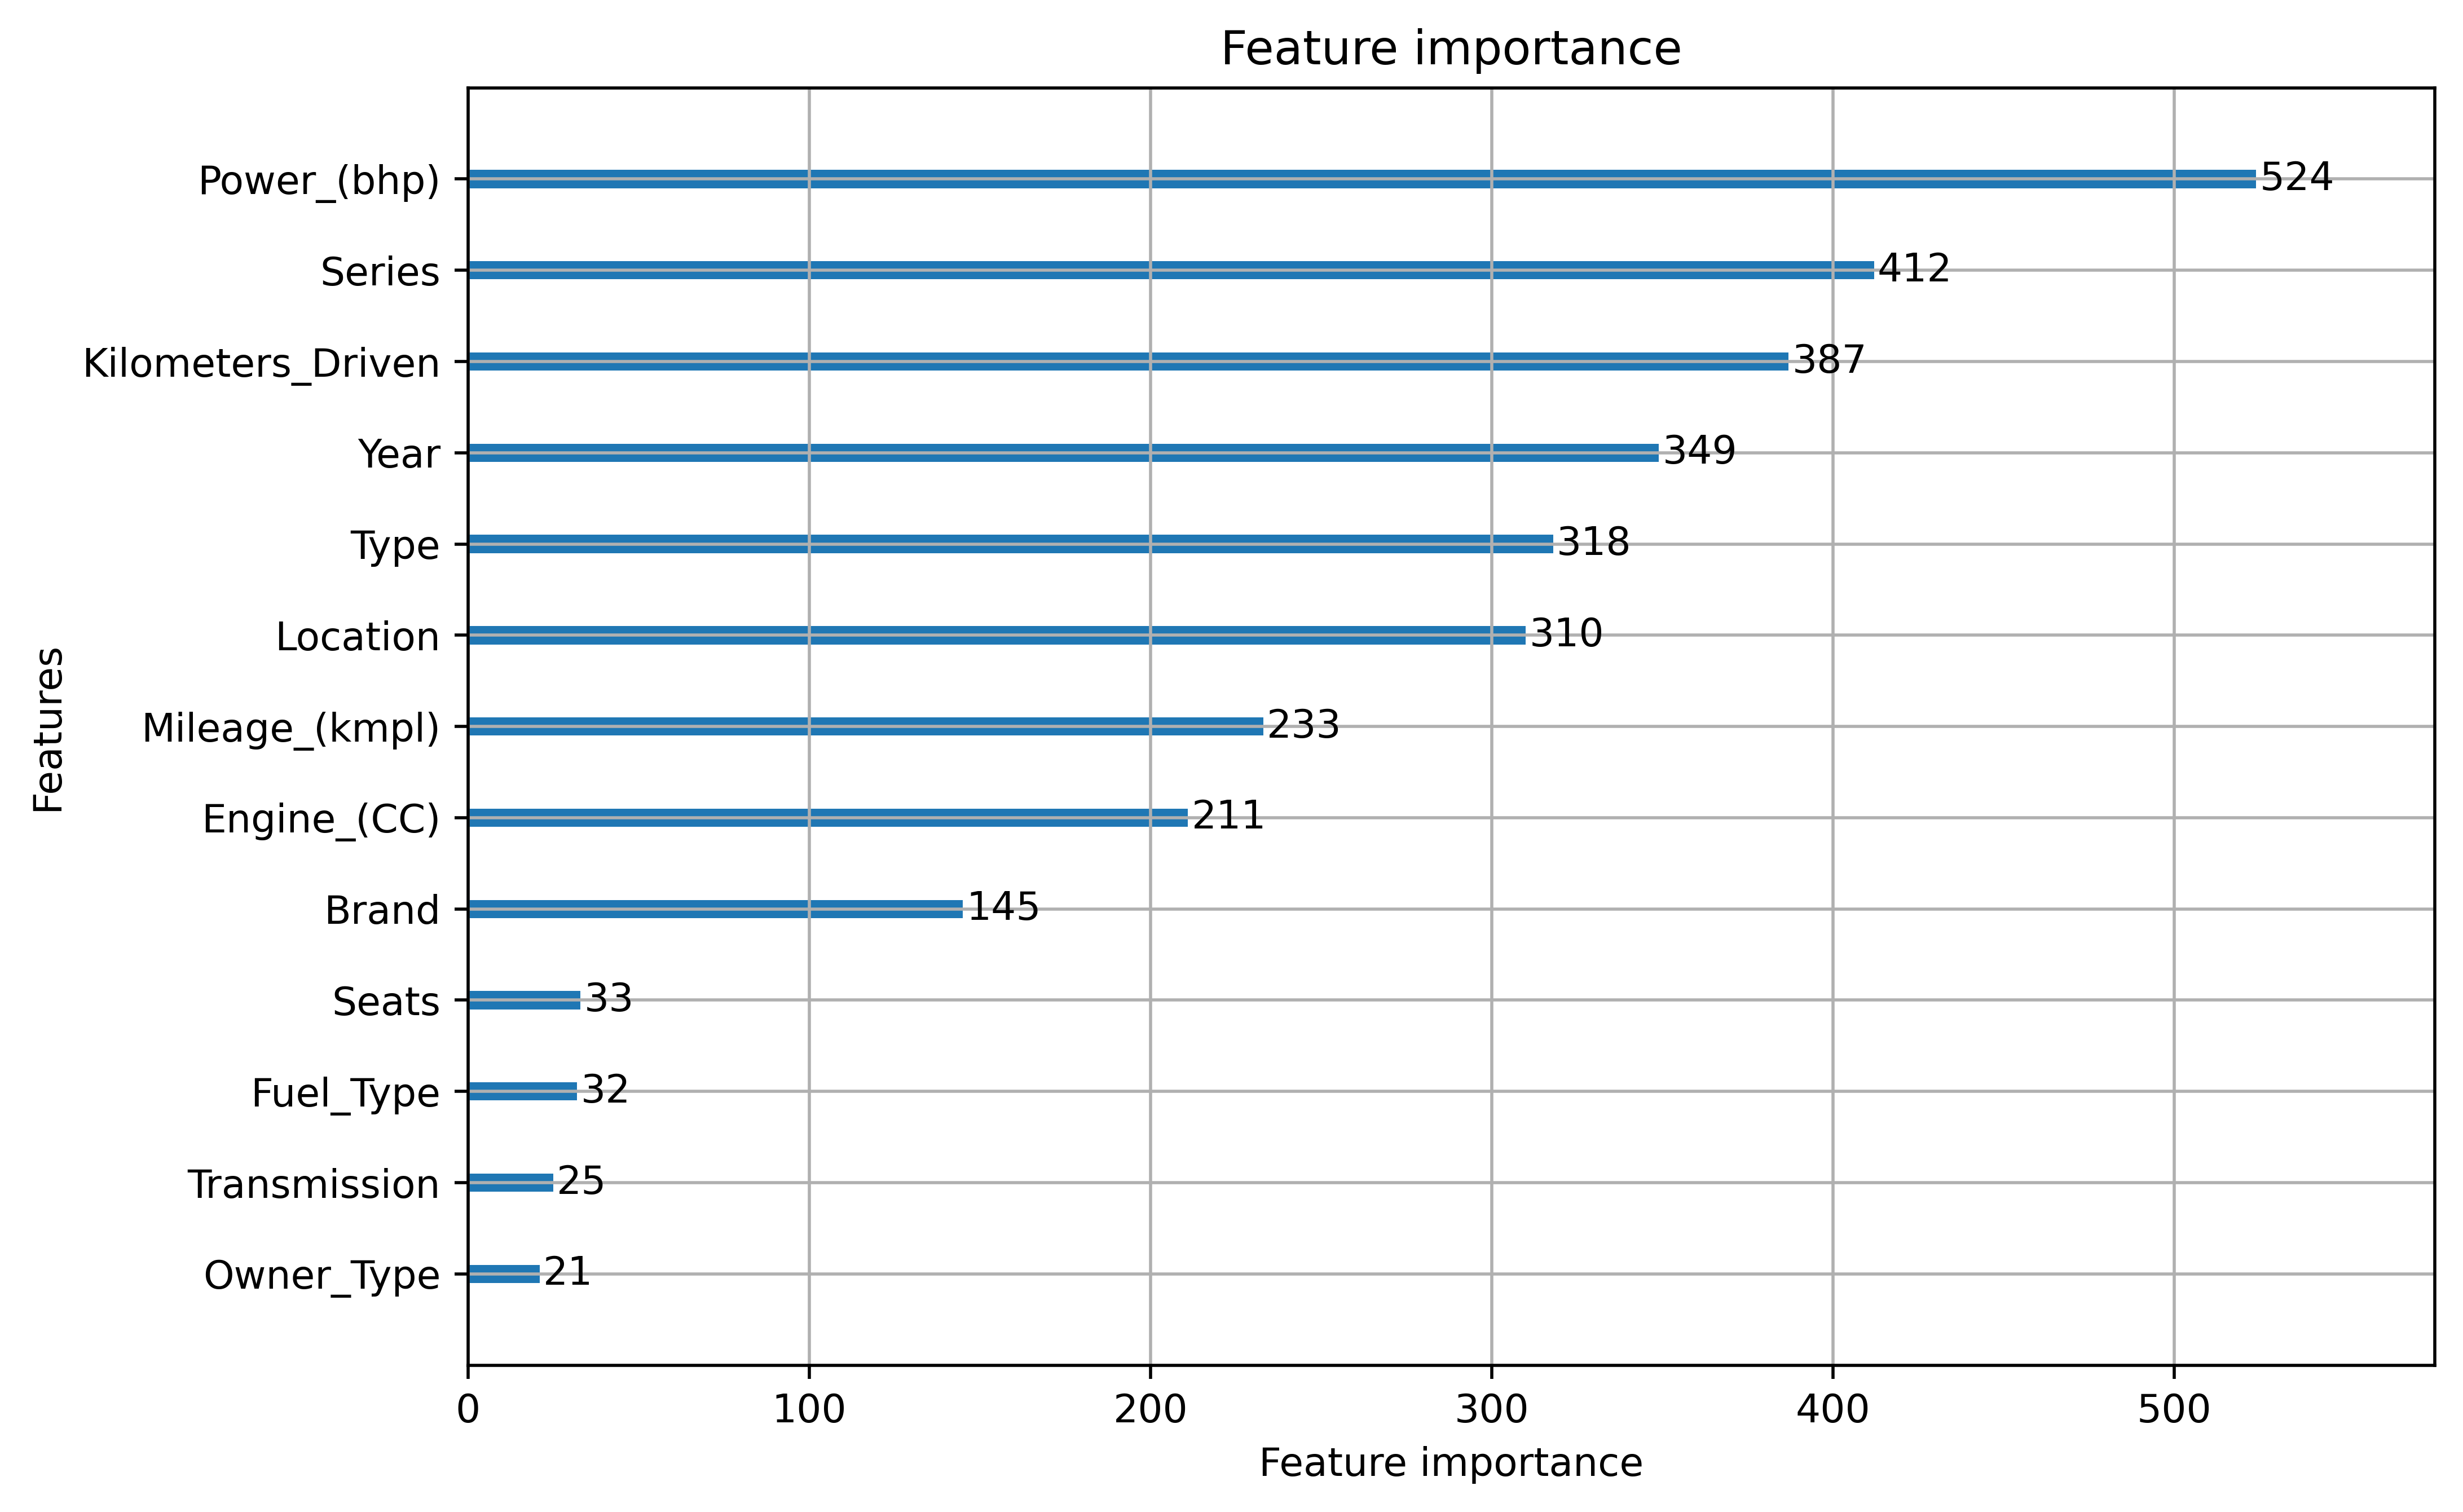

In [13]:
model = LGBMRegressor()
model.fit(X_train_full, y_train)
lgb.plot_importance(model, figsize=(9,6), dpi=500)

<AxesSubplot:>

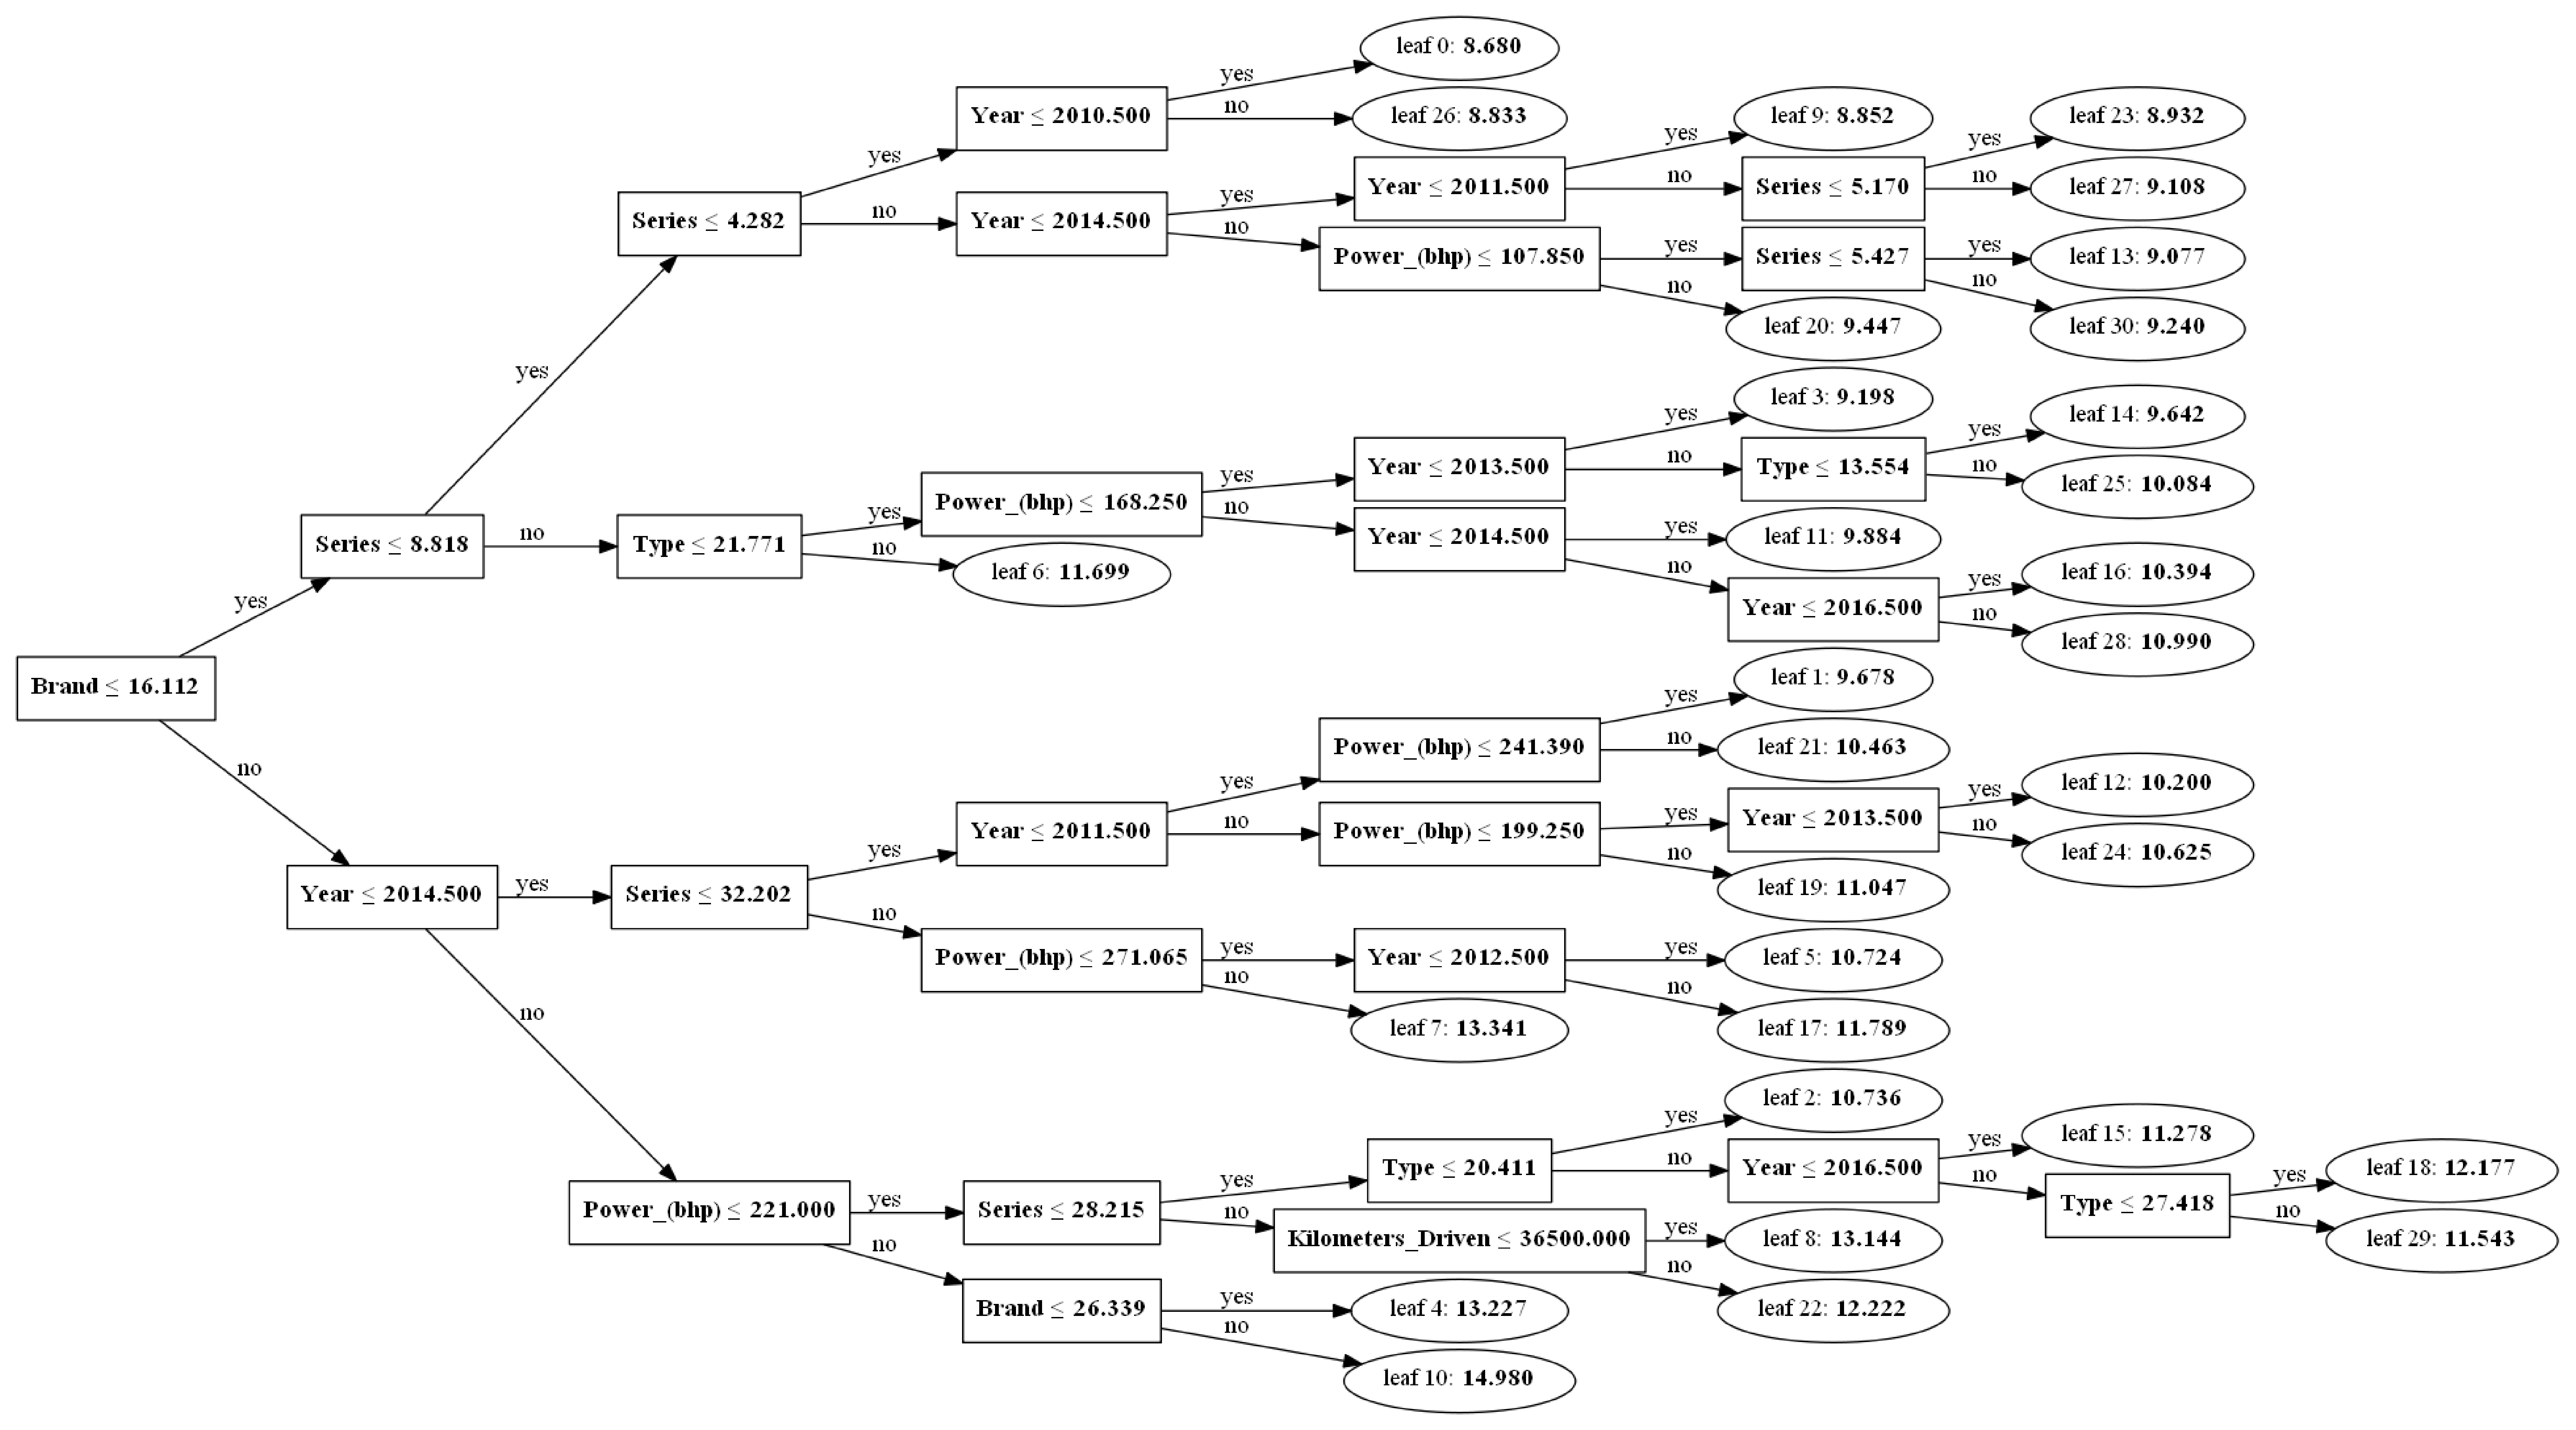

In [14]:
lgb.plot_tree(model, figsize=(8*4,6*4), dpi=300, )